# Eighteenth Century beta of PRISM 

This is a simple but effective example of the power of social network analysis using the principles of using connection to detect 'suspicous activity' in the network of American revolutionaries in the 18th century before the American revolution. We will play with the principles of the NSA's PRISM programme https://en.wikipedia.org/wiki/PRISM_(surveillance_program) but apply these to the 18th century.

The code is adapted from https://kieranhealy.org/blog/archives/2013/06/09/using-metadata-to-find-paul-revere/ and
https://github.com/kjhealy/revere/blob/master/revere.R. Check out Kieran's wonderful work: https://kieranhealy.org/

Kieran introduces his ideas with: 'A brief demonstration of the surprising effectiveness of even the simplest techniques of the new-fangled Social Networke Analysis in the pursuit of those who would seek to undermine the liberty enjoyed by His Majesty’s subjects. This is in connection with the discussion of the role of “metadata” in certain recent events and the assurances of various respectable parties that the government was merely “sifting through this so-called metadata” and that the “information acquired does not include the content of any communications”. I will show how we can use this “metadata” to find key persons involved in terrorist groups operating within the Colonies at the present time (...).' (https://kieranhealy.org/blog/archives/2013/06/09/using-metadata-to-find-paul-revere/).

Let's load the library igraph next, which you should already have installed. Otherwise, please install it first.

In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The data for the analysis is based on the appendix of David Hackett Fischer: Paul Revere's ride. Oxford University Press, 1995. Kieran has done the work of creating the dataset for us. Let's load the data from his github pages.

In [2]:
Paul = pd.read_csv('PaulRevereAppD.csv', index_col=0)
Paul.head()

StAndrewsLodge  LoyalNine  NorthCaucus  LongRoomClub  \
Adams.John                       0          0            1             1   
Adams.Samuel                     0          0            1             1   
Allen.Dr                         0          0            1             0   
Appleton.Nathaniel               0          0            1             0   
Ash.Gilbert                      1          0            0             0   

                    TeaParty  BostonCommittee  LondonEnemies  
Adams.John                 0                0              0  
Adams.Samuel               0                1              1  
Allen.Dr                   0                0              0  
Appleton.Nathaniel         0                1              0  
Ash.Gilbert                0                0              0

Next we create an adjacency matrix (https://en.wikipedia.org/wiki/Adjacency_matrix) using matrix multiplication (%*%). This is quite basic matrix stuff, but you do not need to know how this is exactly calculated. If you are nevertheless interested, please check out https://en.wikipedia.org/wiki/Matrix_multiplication. t is the transpase operator in R (https://en.wikipedia.org/wiki/Transpose). We will create two new adjacency matrixes. The first one counts the number of times a person is in the same group with another person. The second matrix counts the number of members per group. 

You could easily implement the count of groups and people with, for instance, a for loop but matrix multiplication is much more efficient. 

In [3]:
#Count the number of groups two persons are part of!
person = Paul.dot(Paul.T)
person.head()

Adams.John  Adams.Samuel  Allen.Dr  Appleton.Nathaniel  \
Adams.John                   2             2         1                   1   
Adams.Samuel                 2             4         1                   2   
Allen.Dr                     1             1         1                   1   
Appleton.Nathaniel           1             2         1                   2   
Ash.Gilbert                  0             0         0                   0   

                    Ash.Gilbert  Austin.Benjamin  Austin.Samuel  Avery.John  \
Adams.John                    0                0              0           0   
Adams.Samuel                  0                1              1           1   
Allen.Dr                      0                0              0           0   
Appleton.Nathaniel            0                0              0           0   
Ash.Gilbert                   1                0              0           0   

                    Baldwin.Cyrus  Ballard.John  ...  Whitwell.William  \
Adams.John                      0             1  ...                 0   
Adams.Samuel                    1             1  ...                 1   
Allen.Dr                        0             1  ...                 0   
Appleton.Nathaniel              0             1  ...                 0   
Ash.Gilbert                     0             0  ...                 0   

                    Williams.Jeremiah  Williams.Jonathan  Williams.Thomas  \
Adams.John                          0                  0                0   
Adams.Samuel                        0                  1                0   
Allen.Dr                            0                  0                0   
Appleton.Nathaniel                  0                  0                0   
Ash.Gilbert                         0                  0                0   

                    Willis.Nathaniel  Wingfield.William  Winslow.John  \
Adams.John                         0                  0             1   
Adams.Samuel                       0                  0             1   
Allen.Dr                           0                  0             0   
Appleton.Nathaniel                 0                  0             0   
Ash.Gilbert                        0                  1             0   

                    Winthrop.John  Wyeth.Joshua  Young.Thomas  
Adams.John                      1             0             1  
Adams.Samuel                    2             0             2  
Allen.Dr                        1             0             1  
Appleton.Nathaniel              1             0             2  
Ash.Gilbert                     0             0             0  

[5 rows x 254 columns]

In [4]:
#Members in a group
group = Paul.T.dot(Paul)
group.head()

StAndrewsLodge  LoyalNine  NorthCaucus  LongRoomClub  \
StAndrewsLodge              53          2            3             2   
LoyalNine                    2         10            3             0   
NorthCaucus                  3          3           59             5   
LongRoomClub                 2          0            5            17   
TeaParty                     3          2           13             2   

                TeaParty  BostonCommittee  LondonEnemies  
StAndrewsLodge         3                1              3  
LoyalNine              2                0              3  
NorthCaucus           13                9             16  
LongRoomClub           2                5              5  
TeaParty              97                3              8

Next we do some clean up and define all the matrix diagonals as NA, as they are meaningless and transform the dataframe into one that we can use for the graph

In [5]:
np.fill_diagonal(group.values, 333)
group = group.replace(333, np.nan)

groun = group.stack().reset_index()
groun.columns = ['from','to','weight']
groun.head()

from               to  weight
0  StAndrewsLodge        LoyalNine     2.0
1  StAndrewsLodge      NorthCaucus     3.0
2  StAndrewsLodge     LongRoomClub     2.0
3  StAndrewsLodge         TeaParty     3.0
4  StAndrewsLodge  BostonCommittee     1.0

In [6]:
nodes = pd.DataFrame(columns=['group'])
nodes['group'] = groun['from'].unique()
nodes['weight'] = groun['weight']

relations = pd.DataFrame(columns=['source'])
relations['source'] = groun['from']
relations['target'] = groun['to']

G_group = ig.Graph.DictList(
          vertices=nodes.to_dict('records'),
          edges=relations.to_dict('records'),
          directed=True,
          vertex_name_attr='group',
          edge_foreign_keys=('source', 'target'));

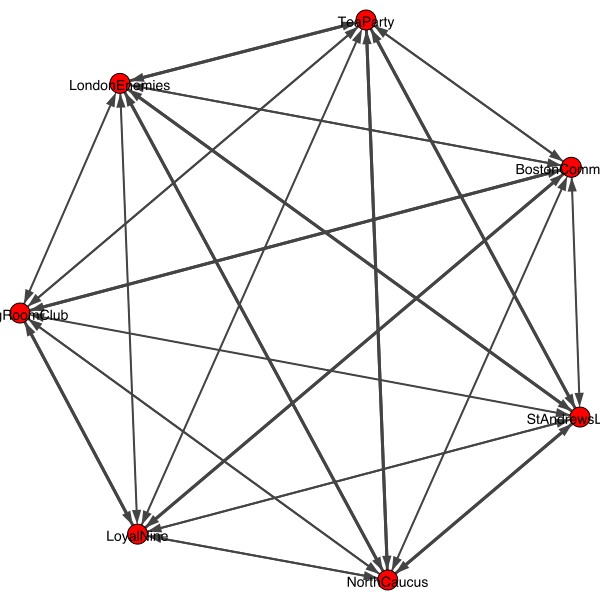

In [7]:
import cairocffi
layout = G_group.layout("Fruchterman_reingold")
ig.plot(G_group, layout = layout, vertex_label=G_group.vs['group'], edge_curved=False, edge_width = [v for v in G_group.vs['weight']])

In [8]:
np.fill_diagonal(person.values, 333)
person = person.replace(333, np.nan)

personn = person.stack().reset_index()
personn.columns = ['from','to','weight']
person_df = personn[personn.weight != 0]
person_df.head()

from                  to  weight
0  Adams.John        Adams.Samuel     2.0
1  Adams.John            Allen.Dr     1.0
2  Adams.John  Appleton.Nathaniel     1.0
8  Adams.John        Ballard.John     1.0
9  Adams.John    Barber.Nathaniel     1.0

In [9]:
nodes = pd.DataFrame(columns=['person'])
nodes['person'] = person_df['from'].unique()
nodes['weight'] = person_df['weight']
nodes['color'] = 'blue'
nodes.loc[nodes['person'] == 'Revere.Paul', 'color'] = 'red'

relations = pd.DataFrame(columns=['source'])
relations['source'] = person_df['from']
relations['target'] = person_df['to']
relations['weight'] = person_df['weight']

G_person = ig.Graph.DictList(
          vertices=nodes.to_dict('records'),
          edges=relations.to_dict('records'),
          directed=False,
          vertex_name_attr='person',
          edge_foreign_keys=('source', 'target'));

Plotting the people in the data and their connections, reveals ...? We mark Paul Revere in red.

In [10]:
import cairocffi
layout = G_person.layout("fr")
ig.plot(G_person, layout=layout, vertex_label=G_person.vs['person'], edge_curved=False, edge_width = [v*0.08 for v in G_person.vs['weight']], edge_arrow_size=0.2, vertex_size=15)

## Finding Paul Revere

Next we apply a number of typical graph measures to get clarity about a complex networks such as the one above. Don't worry if you do not understand them immediately. You can find many explanations on the web that should help you. If after this you have an intuition that should be enough.

### Betweeness

Betweenness is a measure of the centrality of everyone in our graph, which is roughly the number of "shortest paths" between any two people in our network that pass through the person of interest. Or put more simply: "If I have to get from person a to person z, how likely is it that the quickest way is through person x?"

In [11]:
betw = G_person.betweenness()
nodes['betweenness'] = betw
betw_sorted = nodes.sort_values(by=['betweenness'], ascending=False)
betw_sorted[:10]

person  weight color  betweenness
199        Revere.Paul     NaN   red  4371.598675
232       Urann.Thomas     NaN  blue  2371.051282
235      Warren.Joseph     NaN  blue  2256.137689
176        Peck.Samuel     1.0  blue  1418.915474
46        Chase.Thomas     1.0  blue  1219.742276
13          Bass.Henry     NaN  blue  1219.742276
10    Barber.Nathaniel     NaN  blue  1040.361581
193     Proctor.Edward     1.0  blue   847.923067
58   Condy.JamesFoster     1.0  blue   847.923067
92         Grant.Moses     NaN  blue   847.923067

### Eigenvector

The Eigenvector on the other hand measures centrality weighted by a person's connection to other central people.

In [12]:
eg = G_person.eigenvector_centrality()
nodes['eg'] = eg
eg_sorted = nodes.sort_values(by=['eg'], ascending=False)
eg_sorted[:10]

person  weight color  betweenness        eg
199        Revere.Paul     NaN   red  4371.598675  1.000000
10    Barber.Nathaniel     NaN  blue  1040.361581  0.968090
13          Bass.Henry     NaN  blue  1219.742276  0.966538
46        Chase.Thomas     1.0  blue  1219.742276  0.966538
193     Proctor.Edward     1.0  blue   847.923067  0.963693
92         Grant.Moses     NaN  blue   847.923067  0.963693
58   Condy.JamesFoster     1.0  blue   847.923067  0.963693
232       Urann.Thomas     NaN  blue  2371.051282  0.905632
156   Molineux.William     NaN  blue   520.953655  0.889691
253       Young.Thomas     2.0  blue   520.953655  0.889691

### Community Detection

Finally, let's try community detection to again find Paul Revere at the centre.

In [13]:
com = G_person.community_walktrap()
clp = com.as_clustering()

In [14]:
ig.plot(clp, layout=layout, mark_groups=True, vertex_label=G_person.vs['person'])

### Comparison of centralities

Last but not least, let's compare the centrality of suspicious characters in the network. Paul Revere is way on top.

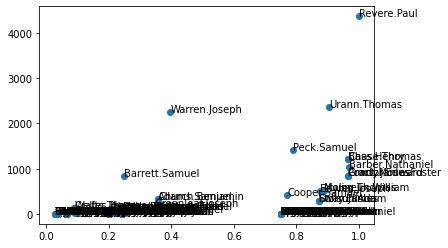

In [15]:
annotations = nodes['person'].to_list()
x = nodes['eg']
y = y=nodes['betweenness']
plt.scatter(x, y)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))
plt.show()